# Features Selection MonoVariate

In [1]:
% matplotlib inline

import time
import pandas as pd

from IPython import display as d

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn import feature_selection as fs
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import (
    KFold, StratifiedKFold, train_test_split)
from sklearn import preprocessing as prp
import sklearn

from libs import container
from libs.experiment import (
    WithAnotherExperiment, KFoldExperiment, roc, 
    discretize_classes, clean_features)

## 1. Load Data

In [2]:
start = time.time()

path = "/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/"
data = container.read(path)

print("Removing b220...")
del data["b220"]

for df in data.values():
    df["AmplitudeJH"] = df["AmplitudeJ"] - df["AmplitudeH"]
    df["AmplitudeJK"] = df["AmplitudeJ"] - df["Amplitude"]

Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b261.npy'...
Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b263.npy'...
Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b220.npy'...
Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b264.npy'...
Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b262.npy'...
Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b278.npy'...
Removing b220...


##  2. Preprocess

### 2.1. Discretize the classes

In [3]:
data, classes, sclasses = discretize_classes(data)
d.display(d.Markdown("**Classes**"))
d.display(classes)

d.display(d.Markdown("----"))
d.display(d.Markdown("**Simplified Classes**"))
d.display(sclasses)

**Classes**

{'': 0,
 'Cep-1': 1,
 'Cep-F': 2,
 'LPV-Mira': 3,
 'LPV-OSARG': 4,
 'LPV-SRV': 5,
 'RRLyr-RRab': 6,
 'RRLyr-RRc': 7,
 'RRLyr-RRd': 8,
 'T2Cep-BLHer': 9,
 'T2Cep-RVTau': 10,
 'T2Cep-WVir': 11}

----

**Simplified Classes**

{'': 0, 'Cep': 1, 'LPV': 2, 'RRLyr': 3, 'T2Cep': 4}

### 2.2. Removes all low-variance and "bad" features

In [4]:
X_columns = clean_features(data, "b278")
X_columns = X_columns.drop("AndersonDarling")
X_columns = X_columns[~(X_columns.str.startswith("Freq2_") | X_columns.str.startswith("Freq3_"))]
print("Total features:", X_columns.size)

Removing ['Gskew', 'Period_fit', 'StetsonK'] because null
Removing ['Freq1_harmonics_rel_phase_0', 'Freq2_harmonics_rel_phase_0', 'Freq3_harmonics_rel_phase_0'] because lowvariance
('Total features:', 55)


### 2.3. Selected features

In [5]:
X_columns

Index([u'cnt', u'Amplitude', u'Autocor_length', u'Beyond1Std', u'CAR_mean',
       u'CAR_sigma', u'CAR_tau', u'Con', u'Eta_e', u'FluxPercentileRatioMid20',
       u'FluxPercentileRatioMid35', u'FluxPercentileRatioMid50',
       u'FluxPercentileRatioMid65', u'FluxPercentileRatioMid80',
       u'Freq1_harmonics_amplitude_0', u'Freq1_harmonics_amplitude_1',
       u'Freq1_harmonics_amplitude_2', u'Freq1_harmonics_amplitude_3',
       u'Freq1_harmonics_rel_phase_1', u'Freq1_harmonics_rel_phase_2',
       u'Freq1_harmonics_rel_phase_3', u'LinearTrend', u'MaxSlope', u'Mean',
       u'Meanvariance', u'MedianAbsDev', u'MedianBRP', u'PairSlopeTrend',
       u'PercentAmplitude', u'PercentDifferenceFluxPercentile', u'PeriodLS',
       u'Psi_CS', u'Psi_eta', u'Q31', u'Rcs', u'Skew', u'SmallKurtosis',
       u'Std', u'c89_jk_color', u'c89_hk_color', u'c89_jh_color',
       u'n09_jk_color', u'n09_hk_color', u'n09_jh_color', u'c89_m2', u'c89_m4',
       u'c89_c3', u'n09_m2', u'n09_m4', u'n09_c3', u'A

In [6]:
sclasses

{'': 0, 'Cep': 1, 'LPV': 2, 'RRLyr': 3, 'T2Cep': 4}

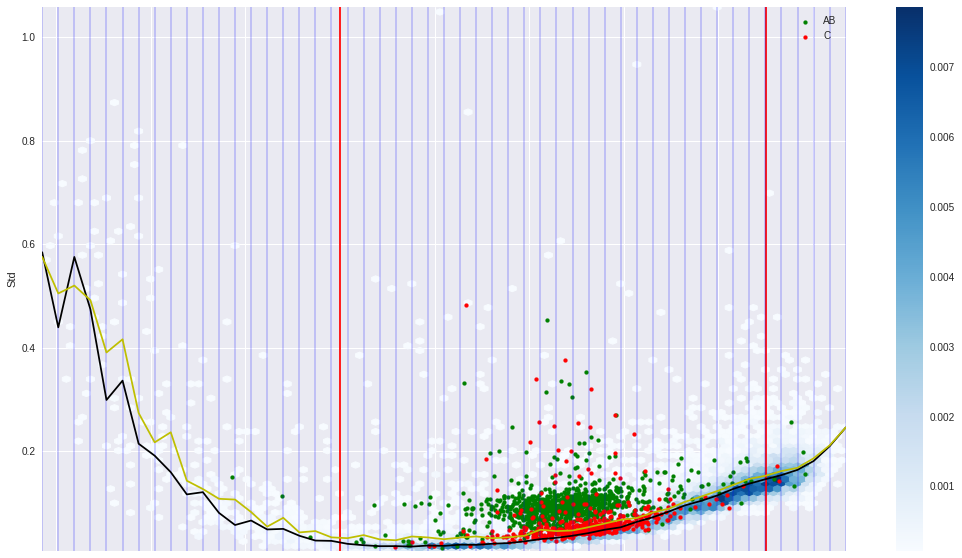

In [7]:
import numpy as np
flt = (12, 16.5)

def plot(data):
    all_df = pd.concat(data.values())
    size = len(all_df)

    all_df['C'] = pd.Series(np.ones(size), index=all_df.index)

    unk = all_df[all_df.cls == 0]
    unk_size = len(unk)

    ax = unk.plot.hexbin(
        "Mean", "Std", cmap="Blues", C="C", 
        reduce_C_function=lambda x: (np.sum(x) / unk_size),
        figsize=(18, 10))

    all_df[all_df.cls == 6].plot.scatter("Mean", "Std", s=15, color="g", ax=ax, label="AB")
    all_df[all_df.cls == 7].plot.scatter("Mean", "Std", s=15, color="r", ax=ax, label="C")

    for limit in flt:
        ax.axvline(limit, color="r")


    bins = np.histogram(unk.Mean, bins=50)[1]

    unk = unk.assign(bins=unk.Mean.apply(np.digitize, bins=bins))

    for idx in bins:
        ax.axvline(idx, color="b", alpha=.2)

    plt.plot(bins, unk.groupby("bins")["Std"].median(), "k")
    plt.plot(bins, unk.groupby("bins")["Std"].mean(), "y")

    return ax
    
plot(data)

## Remove Saturarion

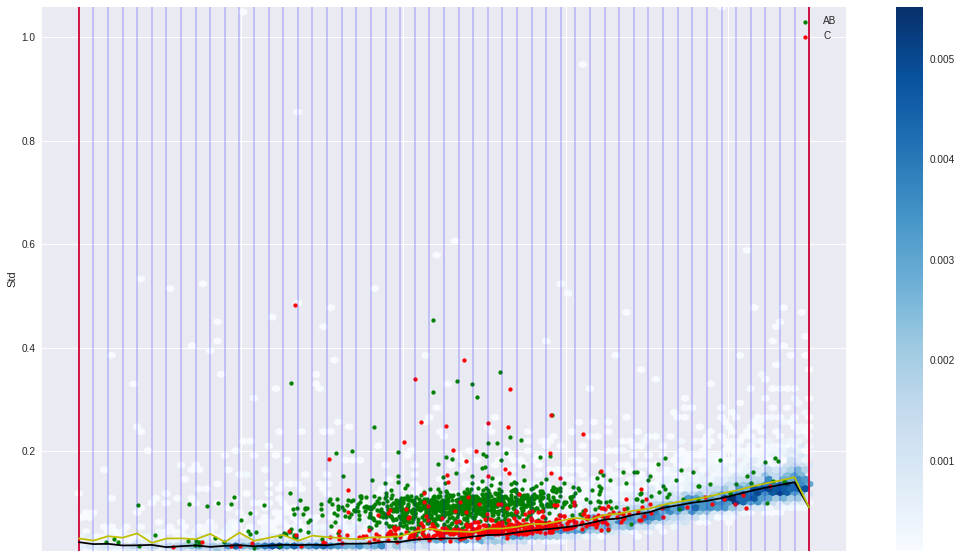

In [8]:
no_saturation = container.Container()
for k, v in data.items():
    no_saturation[k] = v[v.Mean.between(*flt)]
plot(no_saturation)

In [9]:
sclasses

{'': 0, 'Cep': 1, 'LPV': 2, 'RRLyr': 3, 'T2Cep': 4}

In [16]:
tile = container.Container()
tclasses = {}
for idx, item in enumerate(no_saturation.items()):
    k, v = item
    tclasses[k] = idx
    tile[k] = v[v.scls == 3].copy()
    tile[k].loc[:,"tcls"] = idx
tile = pd.concat(tile.values())

In [11]:
tile_unk = container.Container()
for name, cls in tclasses.items():
    tile = no_saturation[name]
    tile_unk[name] = tile[tile.scls == 0].copy().sample(500)
    tile_unk[name].loc[:,"tcls"] = cls
tile_unk = pd.concat(tile_unk.values())

In [12]:
tclasses

{'b261': 2, 'b262': 0, 'b263': 1, 'b264': 4, 'b278': 3}

In [13]:
def experiment(clf, x_train, y_train, x_test, y_test, pos_label):
    x_train = prp.StandardScaler().fit_transform(x_train)
    x_test = prp.StandardScaler().fit_transform(x_test)

    clf = sklearn.clone(clf)
    clf.fit(x_train, y_train)

    predictions = clf.predict(x_test)
    probabilities = clf.predict_proba(x_test)

    fpr, tpr, thresholds = metrics.roc_curve(
        y_test, 1.-probabilities[:,0], pos_label=pos_label)
    prec_rec_curve = metrics.precision_recall_curve(
        y_test, 1.- probabilities[:,0], pos_label=pos_label)
    roc_auc = metrics.auc(fpr, tpr)

    return container.Container({
            'fpr': fpr, 
            'tpr': tpr, 
            'thresh': thresholds, 
            'roc_auc': roc_auc, 
            'prec_rec_curve': prec_rec_curve,
            'y_test': y_test, 
            'predictions': predictions,
            'probabilities': probabilities, 
            'confusion_matrix': metrics.confusion_matrix(y_test, predictions)})


# kfold
def kfolds(data, X_columns, y_column, clf, nfolds):
    skf = StratifiedKFold(n_splits=nfolds)

    subject_df = data

    x = subject_df[X_columns].values
    y = subject_df[y_column].values
    y_real = subject_df[y_column].values

    probabilities = None
    predictions = np.array([])
    y_testing = np.array([])
    y_testing_real = np.array([])

    for train, test in skf.split(x, y):
        x_train = x[train]
        y_train = y[train]
        x_test = x[test]
        y_test = y[test]
        y_test_real = y_real[test]

        rst = experiment(clf, x_train, y_train, x_test, y_test, pos_label=0)            
        
        probabilities = (
            rst.probabilities if probabilities is None else
            np.vstack([probabilities, rst.probabilities]))
        predictions = np.hstack([predictions, rst.predictions])
        y_testing = np.hstack([y_testing, y_test])
        y_testing_real = np.hstack([y_testing_real, y_test_real])
        del rst

    fpr, tpr, thresholds = metrics.roc_curve(
        y_testing, 1.-probabilities[:,0], pos_label=0)
    prec_rec_curve = metrics.precision_recall_curve(
        y_testing, 1.- probabilities[:,0], pos_label=0)
    roc_auc = metrics.auc(fpr, tpr)

    print metrics.classification_report(y_testing, predictions)
    print "-" * 80

    return container.Container({
        'fpr': fpr, 
        'tpr': tpr, 
        'thresh': thresholds, 
        'roc_auc': roc_auc, 
        'prec_rec_curve': prec_rec_curve,
        'y_test': y_testing, 
        'y_test_real': y_testing_real,
        'predictions': predictions,
        'probabilities': probabilities, 
        'confusion_matrix': metrics.confusion_matrix(y_testing, predictions)})

In [18]:
clf = SVC(kernel='poly', probability=True)
kfolds(tile, X_columns, y_column="tcls", clf=clf, nfolds=10)

/home/jbcabral/projects/paper_b278/local/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


             precision    recall  f1-score   support

        0.0       0.18      0.02      0.03       298
        1.0       0.40      0.16      0.23       306
        2.0       0.17      0.01      0.02       220
        3.0       0.29      0.93      0.45       424
        4.0       0.28      0.03      0.05       295

avg / total       0.27      0.30      0.19      1543

--------------------------------------------------------------------------------


<Container({y_test_real, probabilities, predictions, thresh, tpr, fpr, prec_rec_curve, confusion_matrix, y_test, roc_auc})>

In [19]:
min_size = tile.groupby("tcls").size().values.min()
tileb = []
for cls in tclasses.values():
    subset = tile[tile.tcls == cls].copy()
    if len(subset) > min_size:
        subset = subset.sample(min_size)
    tileb.append(subset)
tileb = pd.concat(tileb)

In [20]:
clf = SVC(kernel='poly', probability=True)
kfolds(tileb, X_columns, y_column="tcls", clf=clf, nfolds=10)

             precision    recall  f1-score   support

        0.0       0.22      0.38      0.28       220
        1.0       0.40      0.10      0.17       220
        2.0       0.20      0.50      0.28       220
        3.0       0.33      0.07      0.11       220
        4.0       0.40      0.11      0.18       220

avg / total       0.31      0.23      0.20      1100

--------------------------------------------------------------------------------


<Container({y_test_real, probabilities, predictions, thresh, tpr, fpr, prec_rec_curve, confusion_matrix, y_test, roc_auc})>

In [21]:
clf = SVC(kernel='poly', probability=True)
kfolds(tile_unk, X_columns, y_column="tcls", clf=clf, nfolds=10)

             precision    recall  f1-score   support

        0.0       0.25      0.44      0.32       500
        1.0       0.36      0.27      0.31       500
        2.0       0.21      0.38      0.27       500
        3.0       0.34      0.10      0.16       500
        4.0       0.39      0.12      0.19       500

avg / total       0.31      0.26      0.25      2500

--------------------------------------------------------------------------------


<Container({y_test_real, probabilities, predictions, thresh, tpr, fpr, prec_rec_curve, confusion_matrix, y_test, roc_auc})>

In [22]:
print "\n".join(["{} - {}".format(v, k) for k, v in sorted(tclasses.items(), key=lambda e: e[-1])])

0 - b262
1 - b263
2 - b261
3 - b278
4 - b264
